## Add some feature to the data: daily high, low and avg. for weather variables and total fires per bin.

In [57]:
import sys

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import sklearn as sk

from pickle import dump

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.decomposition import PCA

import helper_functions.config as config
import helper_functions.plotting_functions as plotting_functions
def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn

%matplotlib inline

In [59]:
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"SciKit Learn {sk.__version__}")
print()

Python 3.7.7 (default, Mar 23 2020, 22:36:06) 
[GCC 7.3.0]
Pandas 1.0.3
SciKit Learn 0.23.1



In [3]:
# Window size in hrs for min/max/mean
window_size = 24

In [4]:
# Read data
data = pd.read_parquet(config.raw_data_file)
data.columns = data.columns.str.replace(".", "_")
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28752480 entries, 0 to 28752479
Data columns (total 17 columns):
 #   Column     Dtype         
---  ------     -----         
 0   date_time  datetime64[ns]
 1   lat        float32       
 2   lon        float32       
 3   air_2m     float32       
 4   apcp       float32       
 5   crain      float32       
 6   rhum_2m    float32       
 7   dpt_2m     float32       
 8   pres_sfc   float32       
 9   uwnd_10m   float32       
 10  vwnd_10m   float32       
 11  veg        float32       
 12  lcdc       float32       
 13  hcdc       float32       
 14  mcdc       float32       
 15  vis        float32       
 16  ignition   float32       
dtypes: datetime64[ns](1), float32(16)
memory usage: 2.1 GB


In [5]:
# Drop crain, and, veg and vis because these are not presently avalible from our weather API.
data.drop(['crain', 'veg', 'vis'], inplace=True, axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28752480 entries, 0 to 28752479
Data columns (total 14 columns):
 #   Column     Dtype         
---  ------     -----         
 0   date_time  datetime64[ns]
 1   lat        float32       
 2   lon        float32       
 3   air_2m     float32       
 4   apcp       float32       
 5   rhum_2m    float32       
 6   dpt_2m     float32       
 7   pres_sfc   float32       
 8   uwnd_10m   float32       
 9   vwnd_10m   float32       
 10  lcdc       float32       
 11  hcdc       float32       
 12  mcdc       float32       
 13  ignition   float32       
dtypes: datetime64[ns](1), float32(13)
memory usage: 1.8 GB


### 1. Cloud coverage

In [6]:
# first feature to add is average cloud cover from lcdc, mcdc and hcdc - guessing I will be unable
# to get forcasted data which is that specific.
data['cloud_cover'] = data[['lcdc', 'mcdc','hcdc']].mean(axis=1)
data.drop(['lcdc', 'mcdc','hcdc'], inplace=True, axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28752480 entries, 0 to 28752479
Data columns (total 12 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date_time    datetime64[ns]
 1   lat          float32       
 2   lon          float32       
 3   air_2m       float32       
 4   apcp         float32       
 5   rhum_2m      float32       
 6   dpt_2m       float32       
 7   pres_sfc     float32       
 8   uwnd_10m     float32       
 9   vwnd_10m     float32       
 10  ignition     float32       
 11  cloud_cover  float32       
dtypes: datetime64[ns](1), float32(11)
memory usage: 1.6 GB


In [7]:
data.describe()

,lat,lon,air_2m,apcp,rhum_2m,dpt_2m,pres_sfc,uwnd_10m,vwnd_10m,ignition,cloud_cover
count,2.875248e+07,2.875248e+07,2.875248e+07,2.875248e+07,2.875248e+07,2.875248e+07,2.875248e+07,2.875248e+07,2.875248e+07,2.875248e+07,2.875248e+07
mean,3.712053e+01,-1.195196e+02,2.879437e+02,1.747614e-01,4.925317e+01,2.747225e+02,9.152788e+04,1.055434e+00,1.629087e-01,3.455034e-02,1.467838e+01
std,2.555418e+00,2.505702e+00,1.009653e+01,9.338056e-01,2.623434e+01,7.356117e+00,6.968947e+03,2.685971e+00,3.273967e+00,1.826379e-01,2.254048e+01
min,3.268389e+01,-1.243408e+02,2.465075e+02,0.000000e+00,1.000000e+00,1.921248e+02,6.624355e+04,-2.030144e+01,-2.034747e+01,0.000000e+00,0.000000e+00
25%,3.499029e+01,-1.214709e+02,2.808847e+02,0.000000e+00,2.670697e+01,2.699388e+02,8.715144e+04,-7.210264e-01,-2.033844e+00,0.000000e+00,0.000000e+00
50%,3.681598e+01,-1.198972e+02,2.869814e+02,0.000000e+00,4.562500e+01,2.752963e+02,9.232431e+04,1.048889e+00,1.210175e-01,0.000000e+00,3.000000e+00
75%,3.925970e+01,-1.174117e+02,2.946401e+02,1.939356e-03,7.139391e+01,2.801610e+02,9.708750e+04,2.732604e+00,2.273872e+00,0.000000e+00,2.100000e+01
max,4.197182e+01,-1.143645e+02,3.233755e+02,5.241433e+01,1.000312e+02,2.993494e+02,1.035852e+05,2.156606e+01,3.072835e+01,1.000000e+00,1.000000e+02


### 2. Mean, min and max for continuous weather variables

In [8]:
# Features to include in min/max/mean. Note: crain ,acpc and veg are excluded - c rain is binary, acpc 
# is a 24 hr cumulative sum and veg is not expected to change much on the timescale of days and weeks
input_features = [
    'date_time',
    'lat',
    'lon',
    'air_2m',
    'rhum_2m',
    'dpt_2m',
    'pres_sfc',
    'uwnd_10m',
    'vwnd_10m',
#     'vis',
    'cloud_cover'
]

In [9]:
# Add mean features

# Names for new columns
new_features = {
    'mean_date_time': 'datetime64[ns]',
    'mean_lat': 'float32',
    'mean_lon': 'float32',
    'mean_air_2m': 'float32',
    'mean_rhum_2m': 'float32',
    'mean_dpt_2m': 'float32',
    'mean_pres_sfc': 'float32',
    'mean_uwnd_10m': 'float32', 
    'mean_vwnd_10m': 'float32',
#     'mean_vis': 'float32',
    'mean_cloud_cover': 'float32'
}

# Group by location and calculate mean in rolling window over time
daily_mean = data[input_features].groupby(['lat', 'lon']).rolling(int((window_size/3)), on="date_time").mean()

# Clean up index
daily_mean = daily_mean.droplevel(['lat', 'lon'])
#daily_mean.reset_index(drop=True, inplace=True)

# Rename columns
daily_mean.columns = new_features.keys()

# Set dtypes
daily_mean = daily_mean.astype(new_features)

# Clean up columns
daily_mean.drop(['mean_date_time', 'mean_lat', 'mean_lon'], axis=1, inplace=True)

daily_mean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28752480 entries, 852048 to 28101319
Data columns (total 7 columns):
 #   Column            Dtype  
---  ------            -----  
 0   mean_air_2m       float32
 1   mean_rhum_2m      float32
 2   mean_dpt_2m       float32
 3   mean_pres_sfc     float32
 4   mean_uwnd_10m     float32
 5   mean_vwnd_10m     float32
 6   mean_cloud_cover  float32
dtypes: float32(7)
memory usage: 987.1 MB


In [10]:
# Add max features

# Names for new columns
new_features = {
    'max_date_time': 'datetime64[ns]',
    'max_lat': 'float32',
    'max_lon': 'float32',
    'max_air_2m': 'float32',
    'max_rhum_2m': 'float32',
    'max_dpt_2m': 'float32',
    'max_pres_sfc': 'float32',
    'max_uwnd_10m': 'float32', 
    'max_vwnd_10m': 'float32',
#     'max_vis': 'float32',
    'max_cloud_cover': 'float32'
}

# Group by location and calculate mean in rolling window over time
daily_max = data[input_features].groupby(['lat', 'lon']).rolling(int((window_size/3)), on="date_time").max()

# Clean up index
daily_max = daily_max.droplevel(['lat', 'lon'])
#daily_max.reset_index(drop=True, inplace=True)

# Rename columns
daily_max.columns = new_features.keys()

# Set dtypes
daily_max = daily_max.astype(new_features)

# Clean up columns
daily_max.drop(['max_date_time', 'max_lat', 'max_lon'], axis=1, inplace=True)

daily_max.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28752480 entries, 852048 to 28101319
Data columns (total 7 columns):
 #   Column           Dtype  
---  ------           -----  
 0   max_air_2m       float32
 1   max_rhum_2m      float32
 2   max_dpt_2m       float32
 3   max_pres_sfc     float32
 4   max_uwnd_10m     float32
 5   max_vwnd_10m     float32
 6   max_cloud_cover  float32
dtypes: float32(7)
memory usage: 987.1 MB


In [11]:
# Add min. features

# Names for new columns
new_features = {
    'min_date_time': 'datetime64[ns]',
    'min_lat': 'float32',
    'min_lon': 'float32',
    'min_air_2m': 'float32',
    'min_rhum_2m': 'float32',
    'min_dpt_2m': 'float32',
    'min_pres_sfc': 'float32',
    'min_uwnd_10m': 'float32', 
    'min_vwnd_10m': 'float32',
#     'min_vis': 'float32',
    'min_cloud_cover': 'float32'
}

# Group by location and calculate mean in rolling window over time
daily_min = data[input_features].groupby(['lat', 'lon']).rolling(int((window_size/3)), on="date_time").min()

# Clean up index
daily_min = daily_min.droplevel(['lat', 'lon'])
#daily_min.reset_index(drop=True, inplace=True)

# Rename columns
daily_min.columns = new_features.keys()

# Set dtypes
daily_min = daily_min.astype(new_features)

# Clean up columns
daily_min.drop(['min_date_time', 'min_lat', 'min_lon'], axis=1, inplace=True)

daily_min.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28752480 entries, 852048 to 28101319
Data columns (total 7 columns):
 #   Column           Dtype  
---  ------           -----  
 0   min_air_2m       float32
 1   min_rhum_2m      float32
 2   min_dpt_2m       float32
 3   min_pres_sfc     float32
 4   min_uwnd_10m     float32
 5   min_vwnd_10m     float32
 6   min_cloud_cover  float32
dtypes: float32(7)
memory usage: 987.1 MB


In [12]:
joined = data.join([daily_mean, daily_max, daily_min])
joined.dropna(inplace=True)
joined.head()

,date_time,lat,lon,air_2m,apcp,rhum_2m,dpt_2m,pres_sfc,uwnd_10m,vwnd_10m,...,max_uwnd_10m,max_vwnd_10m,max_cloud_cover,min_air_2m,min_rhum_2m,min_dpt_2m,min_pres_sfc,min_uwnd_10m,min_vwnd_10m,min_cloud_cover
7,1992-01-01 21:00:00,40.297489,-124.340797,284.717224,0.000000,85.786041,282.372498,100324.679688,-2.086864,4.925156,...,-1.780418,6.037125,28.000000,284.702576,85.786041,282.372498,100173.562500,-3.592982,2.589457,3.666667
8,1992-01-02 00:00:00,40.297489,-124.340797,284.771851,0.000000,85.322021,282.354187,100342.968750,-0.500640,3.534446,...,-0.500640,4.925156,28.000000,284.702576,85.322021,282.354187,100324.679688,-3.592982,2.589457,4.666667
9,1992-01-02 03:00:00,40.297489,-124.340797,284.527496,0.000000,85.527054,282.159546,100258.523438,-1.123634,3.270372,...,-0.500640,4.925156,36.333332,284.527496,85.322021,282.159546,100258.523438,-3.592982,2.589457,4.666667
10,1992-01-02 06:00:00,40.297489,-124.340797,284.552765,0.015625,90.107185,282.942993,100356.421875,-1.613294,3.134459,...,-0.500640,4.925156,63.000000,284.527496,85.322021,282.159546,100258.523438,-3.592982,2.706188,4.666667
11,1992-01-02 09:00:00,40.297489,-124.340797,284.501923,0.033476,89.975815,282.855591,100210.109375,-1.872181,3.210251,...,-0.500640,4.925156,83.333336,284.501923,85.322021,282.159546,100210.109375,-3.592982,2.756474,4.666667


In [13]:
joined.describe()

,lat,lon,air_2m,apcp,rhum_2m,dpt_2m,pres_sfc,uwnd_10m,vwnd_10m,ignition,...,max_uwnd_10m,max_vwnd_10m,max_cloud_cover,min_air_2m,min_rhum_2m,min_dpt_2m,min_pres_sfc,min_uwnd_10m,min_vwnd_10m,min_cloud_cover
count,2.874961e+07,2.874961e+07,2.874961e+07,2.874961e+07,2.874961e+07,2.874961e+07,2.874961e+07,2.874961e+07,2.874961e+07,2.874961e+07,...,2.874961e+07,2.874961e+07,2.874961e+07,2.874961e+07,2.874961e+07,2.874961e+07,2.874961e+07,2.874961e+07,2.874961e+07,2.874961e+07
mean,3.712061e+01,-1.195197e+02,2.879438e+02,1.747791e-01,4.925151e+01,2.747230e+02,9.152785e+04,1.055669e+00,1.629511e-01,3.455306e-02,...,3.051982e+00,2.159655e+00,2.872699e+01,2.827704e+02,3.495011e+01,2.721588e+02,9.131617e+04,-8.592135e-01,-1.765579e+00,4.898060e+00
std,2.555418e+00,2.505702e+00,1.009642e+01,9.338506e-01,2.623458e+01,7.356129e+00,6.968932e+03,2.685951e+00,3.274073e+00,1.826449e-01,...,2.607523e+00,3.276427e+00,2.933347e+01,7.983527e+00,2.237022e+01,7.900244e+00,6.959495e+03,2.341571e+00,2.942679e+00,1.166886e+01
min,3.268389e+01,-1.243408e+02,2.465075e+02,0.000000e+00,1.000000e+00,1.921248e+02,6.624355e+04,-2.030144e+01,-2.034747e+01,0.000000e+00,...,-1.572050e+01,-1.748274e+01,0.000000e+00,2.465075e+02,1.000000e+00,1.921248e+02,6.624355e+04,-2.030144e+01,-2.034747e+01,0.000000e+00
25%,3.499029e+01,-1.214709e+02,2.808859e+02,0.000000e+00,2.670531e+01,2.699388e+02,8.715140e+04,-7.207336e-01,-2.033905e+00,0.000000e+00,...,1.346838e+00,-3.073120e-02,3.333333e+00,2.773739e+02,1.684224e+01,2.671834e+02,8.694795e+04,-2.345764e+00,-3.487387e+00,0.000000e+00
50%,3.681598e+01,-1.198972e+02,2.869825e+02,0.000000e+00,4.562462e+01,2.752966e+02,9.232427e+04,1.049149e+00,1.211214e-01,0.000000e+00,...,2.959928e+00,2.131282e+00,1.800000e+01,2.825615e+02,2.925000e+01,2.727960e+02,9.209499e+04,-8.776855e-01,-1.825394e+00,0.000000e+00
75%,3.925970e+01,-1.174117e+02,2.946410e+02,1.939714e-03,7.139133e+01,2.801614e+02,9.708745e+04,2.732774e+00,2.273980e+00,0.000000e+00,...,4.550423e+00,4.065108e+00,4.966667e+01,2.879094e+02,4.866877e+01,2.778646e+02,9.687732e+04,6.860352e-01,2.297354e-01,2.666667e+00
max,4.197182e+01,-1.143645e+02,3.233755e+02,5.241433e+01,1.000312e+02,2.993494e+02,1.035852e+05,2.156606e+01,3.072835e+01,1.000000e+00,...,2.156606e+01,3.072835e+01,1.000000e+02,3.098477e+02,9.998985e+01,2.951255e+02,1.032162e+05,1.591962e+01,2.456506e+01,1.000000e+02


In [14]:
joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28749610 entries, 7 to 28752479
Data columns (total 33 columns):
 #   Column            Dtype         
---  ------            -----         
 0   date_time         datetime64[ns]
 1   lat               float32       
 2   lon               float32       
 3   air_2m            float32       
 4   apcp              float32       
 5   rhum_2m           float32       
 6   dpt_2m            float32       
 7   pres_sfc          float32       
 8   uwnd_10m          float32       
 9   vwnd_10m          float32       
 10  ignition          float32       
 11  cloud_cover       float32       
 12  mean_air_2m       float32       
 13  mean_rhum_2m      float32       
 14  mean_dpt_2m       float32       
 15  mean_pres_sfc     float32       
 16  mean_uwnd_10m     float32       
 17  mean_vwnd_10m     float32       
 18  mean_cloud_cover  float32       
 19  max_air_2m        float32       
 20  max_rhum_2m       float32       
 21  max_dp

In [15]:
# Choose one bin at random and retrive one month worth of data
mask = (joined['date_time'] > '1997-07-01') & (joined['date_time'] <= '1997-07-31')

one_fire = joined[
    (joined['lat'] == 39.30418) &
    (joined['lon'] == -123.2773)
]

one_fire = one_fire.loc[mask]

# Sort data for plotting
one_fire = one_fire.sort_values(by='date_time',ascending=True)

# Add hour number
one_fire.insert(0, 'hour', range(1, (3 * len(one_fire)), 3))

In [16]:
one_fire.head()

,hour,date_time,lat,lon,air_2m,apcp,rhum_2m,dpt_2m,pres_sfc,uwnd_10m,...,max_uwnd_10m,max_vwnd_10m,max_cloud_cover,min_air_2m,min_rhum_2m,min_dpt_2m,min_pres_sfc,min_uwnd_10m,min_vwnd_10m,min_cloud_cover
6029049,1,1997-07-01 03:00:00,39.30418,-123.277298,288.596680,0.0,69.015686,282.872559,95630.250000,2.608502,...,4.63337,2.222260,32.000000,281.964355,51.597454,280.748047,95003.515625,-0.530106,-1.319939,0.0
6029050,4,1997-07-01 06:00:00,39.30418,-123.277298,283.015137,0.0,84.028931,280.412048,95600.539062,1.302326,...,4.63337,2.222260,32.000000,281.964355,51.597454,280.412048,95003.515625,-0.530106,-2.649947,0.0
6029051,7,1997-07-01 09:00:00,39.30418,-123.277298,282.082764,0.0,83.369156,279.391846,95659.007812,0.503730,...,4.63337,2.222260,24.666666,281.964355,51.597454,279.391846,95003.515625,-0.530106,-2.789673,0.0
6029052,10,1997-07-01 12:00:00,39.30418,-123.277298,281.775146,0.0,81.547455,278.762177,95627.078125,0.333006,...,4.63337,2.222260,22.000000,281.775146,51.597454,278.762177,95145.578125,-0.530106,-3.528595,0.0
6029053,13,1997-07-01 15:00:00,39.30418,-123.277298,287.003174,0.0,71.444748,281.887207,95312.132812,1.158273,...,4.63337,1.499489,22.000000,281.775146,51.597454,278.762177,95278.609375,0.333006,-3.758667,0.0


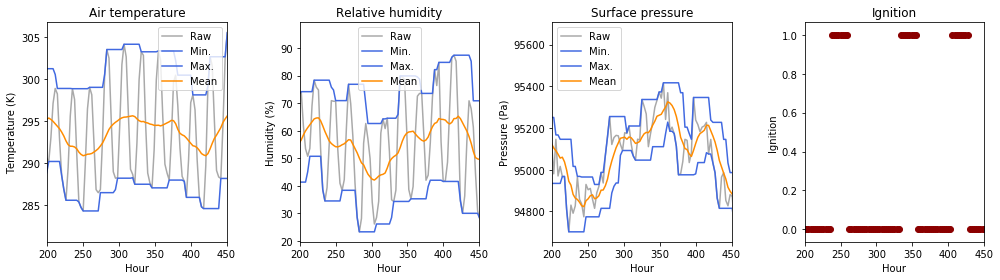

In [17]:
# Plot weather features for single fire
# xmin = min(one_fire['hour'])
# xmax = max(one_fire['hour'])
xmin = 200
xmax = 450

plt.subplots(2,2,figsize=(14,4))

plt.subplot(1, 4, 1)

plt.plot(
    one_fire['hour'], 
    one_fire['air_2m'],
    color = "darkgray",
    label ='Raw'
)
plt.plot(
    one_fire['hour'], 
    one_fire['min_air_2m'],
    color = "royalblue",
    label ='Min.'
)
plt.plot(
    one_fire['hour'], 
    one_fire['max_air_2m'],
    color = "royalblue",
    label ='Max.'
)
plt.plot(
    one_fire['hour'], 
    one_fire['mean_air_2m'],
    color = "darkorange",
    label ='Mean'
)
plt.xlabel('Hour')
plt.ylabel('Temperature (K)')
plt.title('Air temperature')
plt.legend()
plt.xlim(xmin,xmax)


plt.subplot(1, 4, 2)

plt.plot(
    one_fire['hour'], 
    one_fire['rhum_2m'],
    color = "darkgray",
    label ='Raw'
)
plt.plot(
    one_fire['hour'], 
    one_fire['min_rhum_2m'],
    color = "royalblue",
    label ='Min.'
)
plt.plot(
    one_fire['hour'], 
    one_fire['max_rhum_2m'],
    color = "royalblue",
    label ='Max.'
)
plt.plot(
    one_fire['hour'], 
    one_fire['mean_rhum_2m'],
    color = "darkorange",
    label ='Mean'
)
plt.xlabel('Hour')
plt.ylabel('Humidity (%)')
plt.title('Relative humidity')
plt.legend()
plt.xlim(xmin,xmax)


plt.subplot(1, 4, 3)

plt.plot(
    one_fire['hour'], 
    one_fire['pres_sfc'],
    color = "darkgray",
    label ='Raw'
)
plt.plot(
    one_fire['hour'], 
    one_fire['min_pres_sfc'],
    color = "royalblue",
    label ='Min.'
)
plt.plot(
    one_fire['hour'], 
    one_fire['max_pres_sfc'],
    color = "royalblue",
    label ='Max.'
)
plt.plot(
    one_fire['hour'], 
    one_fire['mean_pres_sfc'],
    color = "darkorange",
    label ='Mean'
)
plt.xlabel('Hour')
plt.ylabel('Pressure (Pa)')
plt.title('Surface pressure')
plt.legend()
plt.xlim(xmin,xmax)


plt.subplot(1, 4, 4)

plt.scatter(
    one_fire['hour'], 
    one_fire['ignition'],
    color = "darkred"
)

plt.xlabel('Hour')
plt.ylabel('Ignition')
plt.title('Ignition')
plt.xlim(xmin,xmax)


plt.tight_layout()
plt.savefig('../project_info/figures/CA_only_min_max_mean_added.png', bbox_inches='tight')
plt.show()

**One step further - take daily average to reduce size of dataset**

In [18]:
joined['year'] = pd.DatetimeIndex(joined['date_time']).year.astype('int32')
joined['month'] = pd.DatetimeIndex(joined['date_time']).month.astype('int32')
joined['day'] = pd.DatetimeIndex(joined['date_time']).day.astype('int32')

In [19]:
joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28749610 entries, 7 to 28752479
Data columns (total 36 columns):
 #   Column            Dtype         
---  ------            -----         
 0   date_time         datetime64[ns]
 1   lat               float32       
 2   lon               float32       
 3   air_2m            float32       
 4   apcp              float32       
 5   rhum_2m           float32       
 6   dpt_2m            float32       
 7   pres_sfc          float32       
 8   uwnd_10m          float32       
 9   vwnd_10m          float32       
 10  ignition          float32       
 11  cloud_cover       float32       
 12  mean_air_2m       float32       
 13  mean_rhum_2m      float32       
 14  mean_dpt_2m       float32       
 15  mean_pres_sfc     float32       
 16  mean_uwnd_10m     float32       
 17  mean_vwnd_10m     float32       
 18  mean_cloud_cover  float32       
 19  max_air_2m        float32       
 20  max_rhum_2m       float32       
 21  max_dp

In [20]:
joined = joined.groupby([
    'lat', 
    'lon', 
    'year',
    'month',
    'day'
]).mean().reset_index()

joined.loc[joined['ignition'] > 0, 'ignition'] = 1
joined.reset_index(drop=True, inplace=True)
joined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3594060 entries, 0 to 3594059
Data columns (total 35 columns):
 #   Column            Dtype  
---  ------            -----  
 0   lat               float64
 1   lon               float64
 2   year              int64  
 3   month             int64  
 4   day               int64  
 5   air_2m            float32
 6   apcp              float32
 7   rhum_2m           float32
 8   dpt_2m            float32
 9   pres_sfc          float32
 10  uwnd_10m          float32
 11  vwnd_10m          float32
 12  ignition          float32
 13  cloud_cover       float32
 14  mean_air_2m       float32
 15  mean_rhum_2m      float32
 16  mean_dpt_2m       float32
 17  mean_pres_sfc     float32
 18  mean_uwnd_10m     float32
 19  mean_vwnd_10m     float32
 20  mean_cloud_cover  float32
 21  max_air_2m        float32
 22  max_rhum_2m       float32
 23  max_dpt_2m        float32
 24  max_pres_sfc      float32
 25  max_uwnd_10m      float32
 26  max_vwnd_10m  

In [21]:
#date = pd.to_datetime(joined['year'], joined['month'], joined['day'])
joined['date'] = pd.to_datetime(dict(year=joined.year, month=joined.month, day=joined.day))
joined = joined.astype({'lat': 'float32', 'lon': 'float32'})

In [22]:
to_drop = [
    'year',
    'day',
    'air_2m',
    'rhum_2m',
    'dpt_2m',
    'pres_sfc',
    'uwnd_10m',
    'vwnd_10m',
#     'vis',
    'cloud_cover'
]
joined.drop(to_drop, axis=1, inplace=True)

In [23]:
joined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3594060 entries, 0 to 3594059
Data columns (total 27 columns):
 #   Column            Dtype         
---  ------            -----         
 0   lat               float32       
 1   lon               float32       
 2   month             int64         
 3   apcp              float32       
 4   ignition          float32       
 5   mean_air_2m       float32       
 6   mean_rhum_2m      float32       
 7   mean_dpt_2m       float32       
 8   mean_pres_sfc     float32       
 9   mean_uwnd_10m     float32       
 10  mean_vwnd_10m     float32       
 11  mean_cloud_cover  float32       
 12  max_air_2m        float32       
 13  max_rhum_2m       float32       
 14  max_dpt_2m        float32       
 15  max_pres_sfc      float32       
 16  max_uwnd_10m      float32       
 17  max_vwnd_10m      float32       
 18  max_cloud_cover   float32       
 19  min_air_2m        float32       
 20  min_rhum_2m       float32       
 21  min_dpt_

In [24]:
joined.head()

,lat,lon,month,apcp,ignition,mean_air_2m,mean_rhum_2m,mean_dpt_2m,mean_pres_sfc,mean_uwnd_10m,...,max_vwnd_10m,max_cloud_cover,min_air_2m,min_rhum_2m,min_dpt_2m,min_pres_sfc,min_uwnd_10m,min_vwnd_10m,min_cloud_cover,date
0,32.683891,-117.180901,1,0.000000,0.0,286.606018,74.662338,281.556610,100993.335938,-0.801620,...,0.545212,28.000000,283.245331,43.161045,279.903748,100793.164062,-2.931666,-2.614124,5.333333,1992-01-01
1,32.683891,-117.180901,1,0.140377,0.0,286.819366,71.860176,281.242249,100867.898438,-1.993129,...,1.886511,62.250000,283.482178,43.104851,279.498657,100611.046875,-3.747156,-2.614873,6.708333,1992-01-02
2,32.683891,-117.180901,1,0.546172,0.0,286.278076,78.299187,282.128052,100411.867188,-1.289372,...,2.854177,99.583328,284.181427,48.171734,279.066284,100169.203125,-3.350207,-1.960777,52.833332,1992-01-03
3,32.683891,-117.180901,1,0.045318,0.0,286.123779,89.555878,284.345551,100226.726562,-0.733278,...,3.824692,64.666664,284.758636,80.011002,283.526276,100019.046875,-1.533989,1.155087,15.541666,1992-01-04
4,32.683891,-117.180901,1,3.400671,0.0,287.310150,82.154648,284.156281,100333.875000,-0.073470,...,4.521461,47.208332,284.986877,70.819626,282.767273,100175.546875,-1.705194,1.410801,21.125000,1992-01-05


In [25]:
# Choose one bin at random and retrive one month worth of data
mask = (joined['date'] > '1997-07-01') & (joined['date'] <= '1997-07-31')

one_fire = joined[
    (joined['lat'] == 39.30418) &
    (joined['lon'] == -123.2773)
]

one_fire = one_fire.loc[mask]

# Sort data for plotting
one_fire = one_fire.sort_values(by='date',ascending=True)

# Add hour number
one_fire.insert(0, 'hour', range(1, (24 * len(one_fire)), 24))

In [26]:
one_fire.head()

,hour,lat,lon,month,apcp,ignition,mean_air_2m,mean_rhum_2m,mean_dpt_2m,mean_pres_sfc,...,max_vwnd_10m,max_cloud_cover,min_air_2m,min_rhum_2m,min_dpt_2m,min_pres_sfc,min_uwnd_10m,min_vwnd_10m,min_cloud_cover,date
2701937,1,39.30418,-123.277298,7,0.000533,0.0,289.250244,65.729630,282.186554,95364.781250,...,-3.349424,0.000000,282.575439,41.791698,279.663269,95226.562500,0.784963,-6.823574,0.0,1997-07-02
2701938,25,39.30418,-123.277298,7,0.000711,0.0,293.196106,54.801868,282.962463,95169.265625,...,-3.595974,0.000000,285.727783,34.100792,279.974060,95027.929688,0.774209,-6.307178,0.0,1997-07-03
2701939,49,39.30418,-123.277298,7,0.000000,0.0,295.037628,52.533894,284.143250,94970.898438,...,-2.945038,0.000000,287.616699,33.685963,280.648926,94903.328125,0.999351,-5.040770,0.0,1997-07-04
2701940,73,39.30418,-123.277298,7,0.001275,0.0,293.130615,59.244678,284.337524,94987.703125,...,-2.704640,0.000000,286.400024,39.510174,281.779541,94899.437500,1.536826,-5.341434,0.0,1997-07-05
2701941,97,39.30418,-123.277298,7,0.001143,0.0,291.892761,63.539677,284.382751,95211.421875,...,-3.668743,3.916667,285.675537,46.541904,281.627258,95060.210938,2.185912,-6.545231,0.0,1997-07-06


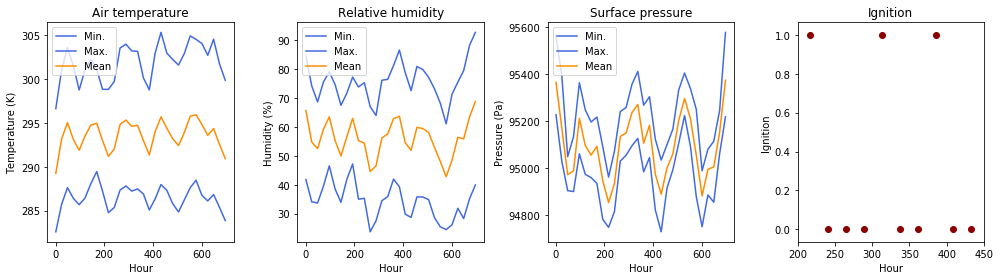

In [27]:
# Plot weather features for single fire
# xmin = min(one_fire['hour'])
# xmax = max(one_fire['hour'])
xmin = 200
xmax = 450

plt.subplots(2,2,figsize=(14,4))

plt.subplot(1, 4, 1)

plt.plot(
    one_fire['hour'], 
    one_fire['min_air_2m'],
    color = "royalblue",
    label ='Min.'
)
plt.plot(
    one_fire['hour'], 
    one_fire['max_air_2m'],
    color = "royalblue",
    label ='Max.'
)
plt.plot(
    one_fire['hour'], 
    one_fire['mean_air_2m'],
    color = "darkorange",
    label ='Mean'
)
plt.xlabel('Hour')
plt.ylabel('Temperature (K)')
plt.title('Air temperature')
plt.legend()
#plt.xlim(xmin,xmax)


plt.subplot(1, 4, 2)

plt.plot(
    one_fire['hour'], 
    one_fire['min_rhum_2m'],
    color = "royalblue",
    label ='Min.'
)
plt.plot(
    one_fire['hour'], 
    one_fire['max_rhum_2m'],
    color = "royalblue",
    label ='Max.'
)
plt.plot(
    one_fire['hour'], 
    one_fire['mean_rhum_2m'],
    color = "darkorange",
    label ='Mean'
)
plt.xlabel('Hour')
plt.ylabel('Humidity (%)')
plt.title('Relative humidity')
plt.legend()
#plt.xlim(xmin,xmax)


plt.subplot(1, 4, 3)

plt.plot(
    one_fire['hour'], 
    one_fire['min_pres_sfc'],
    color = "royalblue",
    label ='Min.'
)
plt.plot(
    one_fire['hour'], 
    one_fire['max_pres_sfc'],
    color = "royalblue",
    label ='Max.'
)
plt.plot(
    one_fire['hour'], 
    one_fire['mean_pres_sfc'],
    color = "darkorange",
    label ='Mean'
)
plt.xlabel('Hour')
plt.ylabel('Pressure (Pa)')
plt.title('Surface pressure')
plt.legend()
#plt.xlim(xmin,xmax)


plt.subplot(1, 4, 4)

plt.scatter(
    one_fire['hour'], 
    one_fire['ignition'],
    color = "darkred",
    label = "Spread"
)

plt.xlabel('Hour')
plt.ylabel('Ignition')
plt.title('Ignition')
plt.xlim(xmin,xmax)


plt.tight_layout()
plt.savefig('../project_info/figures/CA_only_daily_mean_min_max_mean_added.png', bbox_inches='tight')
plt.show()

In [28]:
raw_percent_ignition = np.round(((len(data[data['ignition'] == 1])/len(data))*100),2)
joined_percent_ignition = np.round(((len(joined[joined['ignition'] == 1])/len(joined))*100),2)
print("Raw data is {}% ignition".format(raw_percent_ignition))
print("Processed data is {}% ignition".format(joined_percent_ignition))

Raw data is 3.46% ignition
Processed data is 3.46% ignition









**Add total fires per lat/lon bin**

In [29]:
total_fires = data[['lat', 'lon', 'ignition']].groupby(['lat', 'lon']).sum()
joined['total_fires'] = joined.apply(lambda x: total_fires.loc[(x['lat'], x['lon'])], axis=1)
total_fires.to_csv('/mnt/SSD/data/training_data/1992-2015_california_total_fires_per_bin.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3594060 entries, 0 to 3594059
Data columns (total 28 columns):
 #   Column            Dtype         
---  ------            -----         
 0   lat               float32       
 1   lon               float32       
 2   month             int64         
 3   apcp              float32       
 4   ignition          float32       
 5   mean_air_2m       float32       
 6   mean_rhum_2m      float32       
 7   mean_dpt_2m       float32       
 8   mean_pres_sfc     float32       
 9   mean_uwnd_10m     float32       
 10  mean_vwnd_10m     float32       
 11  mean_cloud_cover  float32       
 12  max_air_2m        float32       
 13  max_rhum_2m       float32       
 14  max_dpt_2m        float32       
 15  max_pres_sfc      float32       
 16  max_uwnd_10m      float32       
 17  max_vwnd_10m      float32       
 18  max_cloud_cover   float32       
 19  min_air_2m        float32       
 20  min_rhum_2m       float32       
 21  min_dpt_

In [35]:
dtypes = {
    'lat':                 'float32',
    'lon':                 'float32',
    'month':               'int32',
#     'crain':               'int32',
#     'veg':                 'float32',
    'ignition':            'int32',
    'mean_air_2m':         'float32',
    'mean_rhum_2m':        'float32',
    'mean_dpt_2m':         'float32',
    'mean_pres_sfc':       'float32',
    'mean_uwnd_10m':       'float32',
    'mean_vwnd_10m':       'float32',
#     'mean_vis':            'float32',
    'mean_cloud_cover':    'float32',
    'max_air_2m':          'float32',
    'max_rhum_2m':         'float32',
    'max_dpt_2m':          'float32',
    'max_pres_sfc':        'float32',
    'max_uwnd_10m':        'float32',
    'max_vwnd_10m':        'float32',
#     'max_vis':             'float32',
    'max_cloud_cover':     'float32',
    'min_air_2m':          'float32',
    'min_rhum_2m':         'float32',
    'min_dpt_2m':          'float32',
    'min_pres_sfc':        'float32',
    'min_uwnd_10m':        'float32',
    'min_vwnd_10m':        'float32',
#     'min_vis':             'float32',
    'min_cloud_cover':     'float32',
    'total_fires':         'int32',
    'date':                'datetime64[ns]'
}

joined = joined.astype(dtypes)

In [36]:
joined.head()

,lat,lon,month,apcp,ignition,mean_air_2m,mean_rhum_2m,mean_dpt_2m,mean_pres_sfc,mean_uwnd_10m,...,max_cloud_cover,min_air_2m,min_rhum_2m,min_dpt_2m,min_pres_sfc,min_uwnd_10m,min_vwnd_10m,min_cloud_cover,date,total_fires
0,32.683891,-117.180901,1,0.000000,0,286.606018,74.662338,281.556610,100993.335938,-0.801620,...,28.000000,283.245331,43.161045,279.903748,100793.164062,-2.931666,-2.614124,5.333333,1992-01-01,1248
1,32.683891,-117.180901,1,0.140377,0,286.819366,71.860176,281.242249,100867.898438,-1.993129,...,62.250000,283.482178,43.104851,279.498657,100611.046875,-3.747156,-2.614873,6.708333,1992-01-02,1248
2,32.683891,-117.180901,1,0.546172,0,286.278076,78.299187,282.128052,100411.867188,-1.289372,...,99.583328,284.181427,48.171734,279.066284,100169.203125,-3.350207,-1.960777,52.833332,1992-01-03,1248
3,32.683891,-117.180901,1,0.045318,0,286.123779,89.555878,284.345551,100226.726562,-0.733278,...,64.666664,284.758636,80.011002,283.526276,100019.046875,-1.533989,1.155087,15.541666,1992-01-04,1248
4,32.683891,-117.180901,1,3.400671,0,287.310150,82.154648,284.156281,100333.875000,-0.073470,...,47.208332,284.986877,70.819626,282.767273,100175.546875,-1.705194,1.410801,21.125000,1992-01-05,1248


In [37]:
joined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3594060 entries, 0 to 3594059
Data columns (total 28 columns):
 #   Column            Dtype         
---  ------            -----         
 0   lat               float32       
 1   lon               float32       
 2   month             int32         
 3   apcp              float32       
 4   ignition          int32         
 5   mean_air_2m       float32       
 6   mean_rhum_2m      float32       
 7   mean_dpt_2m       float32       
 8   mean_pres_sfc     float32       
 9   mean_uwnd_10m     float32       
 10  mean_vwnd_10m     float32       
 11  mean_cloud_cover  float32       
 12  max_air_2m        float32       
 13  max_rhum_2m       float32       
 14  max_dpt_2m        float32       
 15  max_pres_sfc      float32       
 16  max_uwnd_10m      float32       
 17  max_vwnd_10m      float32       
 18  max_cloud_cover   float32       
 19  min_air_2m        float32       
 20  min_rhum_2m       float32       
 21  min_dpt_

In [38]:
joined.to_parquet('/mnt/SSD/data/training_data/1992-2015_california_min-max_added.parquet')

In [39]:
joined = pd.read_parquet('/mnt/SSD/data/training_data/1992-2015_california_min-max_added.parquet')

raw_lat = joined['lat']
raw_lon = joined['lon']
dates = joined['date']

In [40]:
joined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3594060 entries, 0 to 3594059
Data columns (total 28 columns):
 #   Column            Dtype         
---  ------            -----         
 0   lat               float32       
 1   lon               float32       
 2   month             int32         
 3   apcp              float32       
 4   ignition          int32         
 5   mean_air_2m       float32       
 6   mean_rhum_2m      float32       
 7   mean_dpt_2m       float32       
 8   mean_pres_sfc     float32       
 9   mean_uwnd_10m     float32       
 10  mean_vwnd_10m     float32       
 11  mean_cloud_cover  float32       
 12  max_air_2m        float32       
 13  max_rhum_2m       float32       
 14  max_dpt_2m        float32       
 15  max_pres_sfc      float32       
 16  max_uwnd_10m      float32       
 17  max_vwnd_10m      float32       
 18  max_cloud_cover   float32       
 19  min_air_2m        float32       
 20  min_rhum_2m       float32       
 21  min_dpt_

## 1) Mean only: raw

In [41]:
feature_names = [
    'lat',
    'lon',
    'month',
    'apcp',
#     'crain',
#     'veg',
    'mean_air_2m',    
    'mean_rhum_2m', 
    'mean_dpt_2m', 
    'mean_pres_sfc', 
    'mean_uwnd_10m', 
    'mean_vwnd_10m', 
#     'mean_vis', 
    'mean_cloud_cover',
    'total_fires',
    'ignition'
]

raw_data = joined[feature_names]
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3594060 entries, 0 to 3594059
Data columns (total 13 columns):
 #   Column            Dtype  
---  ------            -----  
 0   lat               float32
 1   lon               float32
 2   month             int32  
 3   apcp              float32
 4   mean_air_2m       float32
 5   mean_rhum_2m      float32
 6   mean_dpt_2m       float32
 7   mean_pres_sfc     float32
 8   mean_uwnd_10m     float32
 9   mean_vwnd_10m     float32
 10  mean_cloud_cover  float32
 11  total_fires       int32  
 12  ignition          int32  
dtypes: float32(10), int32(3)
memory usage: 178.2 MB


In [42]:
raw_data['raw_lat'] = raw_lat
raw_data['raw_lon'] = raw_lon
raw_data['date'] = dates

raw_data.to_parquet('/mnt/SSD/data/training_data/1992-2015_california_raw_mean.parquet')

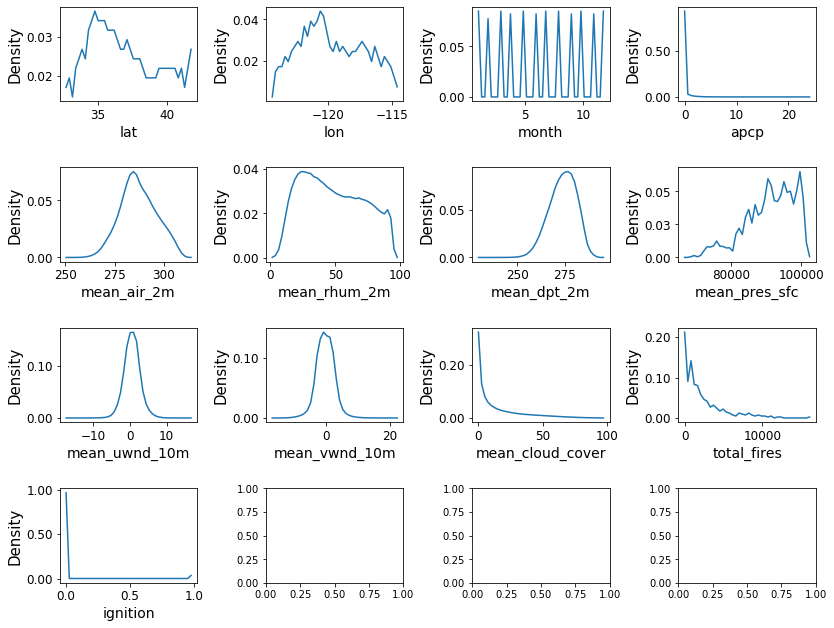

In [43]:
# plot weather data distributions
left = config.left
right = config.right
bottom = config.bottom
top = config.top
wspace = config.wspace
hspace = config.hspace
fig_rows = 4
fig_cols = 4
plot_height = 10
plot_width = config.plot_width

plot_locations = [
    (0,0),(0,1),(0,2),(0,3),
    (1,0),(1,1),(1,2),(1,3),
    (2,0),(2,1),(2,2),(2,3),
    (3,0),(3,1),(3,2),(3,3)
]

xlabels = feature_names
ylabels = ['Density'] * len(feature_names)

fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for i in range(len(feature_names)):
    ax[plot_locations[i]] = plotting_functions.one_sample_density_plot(
        ax,
        plot_locations[i], 
        raw_data, 
        feature_names[i], 
        feature_names[i], 
        feature_names[i], 
        ylabels[i]
    )

## 2) Mean only: (0, 1) scaled

In [61]:
# min-max scale data into (0, 1)

features_to_scale = [
    'lat',       
    'lon',       
    'month',         
    'apcp',    
#     'crain',     
#     'veg',     
#     'ignition',       
    'mean_air_2m',      
    'mean_rhum_2m',    
    'mean_dpt_2m',     
    'mean_pres_sfc',     
    'mean_uwnd_10m',  
    'mean_vwnd_10m',   
#     'mean_vis',      
    'mean_cloud_cover',         
    'total_fires'
]

data_types = {      
    'lat': 'float32',       
    'lon': 'float32',  
    'month': 'float32',         
    'apcp': 'float32',    
#     'crain': 'int32',     
#     'veg': 'float32',     
    'ignition': 'int32',       
    'mean_air_2m': 'float32',      
    'mean_rhum_2m': 'float32',    
    'mean_dpt_2m': 'float32',     
    'mean_pres_sfc': 'float32',     
    'mean_uwnd_10m': 'float32',  
    'mean_vwnd_10m': 'float32',   
#     'mean_vis': 'float32',      
    'mean_cloud_cover': 'float32',       
    'total_fires': 'float32',      
}

scaled_data = raw_data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data[features_to_scale] = scaler.fit_transform(raw_data[features_to_scale])

dump(scaler, open('./data_transformations/min0_max1_scaler', 'wb'))

scaled_data = scaled_data.astype(data_types)

scaled_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3594060 entries, 0 to 3594059
Data columns (total 16 columns):
 #   Column            Dtype         
---  ------            -----         
 0   lat               float32       
 1   lon               float32       
 2   month             float32       
 3   apcp              float32       
 4   mean_air_2m       float32       
 5   mean_rhum_2m      float32       
 6   mean_dpt_2m       float32       
 7   mean_pres_sfc     float32       
 8   mean_uwnd_10m     float32       
 9   mean_vwnd_10m     float32       
 10  mean_cloud_cover  float32       
 11  total_fires       float32       
 12  ignition          int32         
 13  raw_lat           float32       
 14  raw_lon           float32       
 15  date              datetime64[ns]
dtypes: datetime64[ns](1), float32(14), int32(1)
memory usage: 233.1 MB


In [62]:
scaled_data['raw_lat'] = raw_lat
scaled_data['raw_lon'] = raw_lon
scaled_data['date'] = dates

scaled_data.to_parquet('/mnt/SSD/data/training_data/1992-2015_california_min0_max1_scaled_mean.parquet')

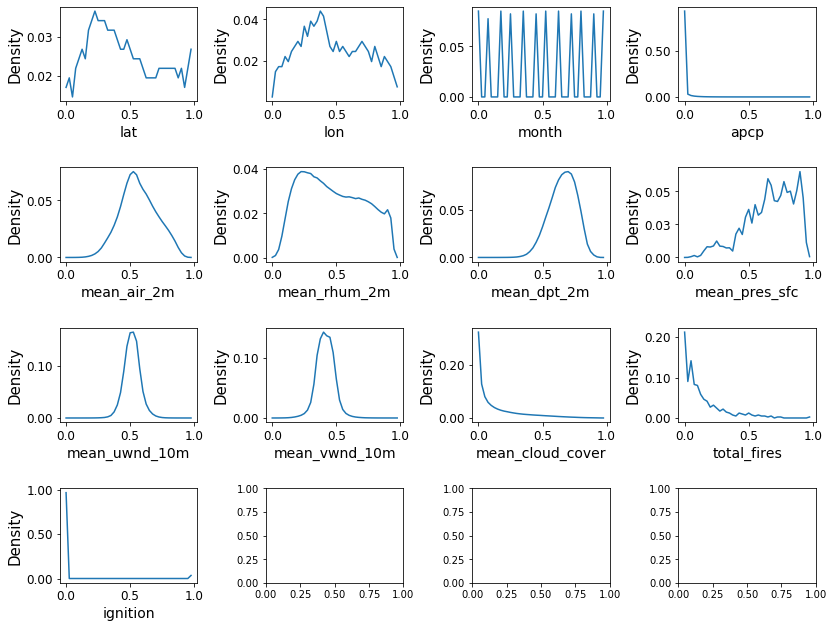

In [63]:
# plot weather data distributions
left = config.left
right = config.right
bottom = config.bottom
top = config.top
wspace = config.wspace
hspace = config.hspace
fig_rows = 4
fig_cols = 4
plot_height = 10
plot_width = config.plot_width

plot_locations = [
    (0,0),(0,1),(0,2),(0,3),
    (1,0),(1,1),(1,2),(1,3),
    (2,0),(2,1),(2,2),(2,3),
    (3,0),(3,1),(3,2),(3,3)
]

xlabels = feature_names
ylabels = ['Density'] * len(feature_names)

fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for i in range(len(feature_names)):
    ax[plot_locations[i]] = plotting_functions.one_sample_density_plot(
        ax,
        plot_locations[i], 
        scaled_data, 
        feature_names[i], 
        feature_names[i], 
        feature_names[i], 
        ylabels[i]
    )

## 3) Mean only: (-1, 1) scaled

In [64]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data[features_to_scale] = scaler.fit_transform(raw_data[features_to_scale])

dump(scaler, open('./data_transformations/min-1_max1_scaler', 'wb'))

scaled_data = scaled_data.astype(data_types)

scaled_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3594060 entries, 0 to 3594059
Data columns (total 16 columns):
 #   Column            Dtype         
---  ------            -----         
 0   lat               float32       
 1   lon               float32       
 2   month             float32       
 3   apcp              float32       
 4   mean_air_2m       float32       
 5   mean_rhum_2m      float32       
 6   mean_dpt_2m       float32       
 7   mean_pres_sfc     float32       
 8   mean_uwnd_10m     float32       
 9   mean_vwnd_10m     float32       
 10  mean_cloud_cover  float32       
 11  total_fires       float32       
 12  ignition          int32         
 13  raw_lat           float32       
 14  raw_lon           float32       
 15  date              datetime64[ns]
dtypes: datetime64[ns](1), float32(14), int32(1)
memory usage: 233.1 MB


In [48]:
scaled_data['raw_lat'] = raw_lat
scaled_data['raw_lon'] = raw_lon
scaled_data['date'] = dates

scaled_data.to_parquet('/mnt/SSD/data/training_data/1992-2015_california_min-1_max1_scaled_mean.parquet')

In [ ]:
# plot weather data distributions
left = config.left
right = config.right
bottom = config.bottom
top = config.top
wspace = config.wspace
hspace = config.hspace
fig_rows = 4
fig_cols = 4
plot_height = 10
plot_width = config.plot_width

plot_locations = [
    (0,0),(0,1),(0,2),(0,3),
    (1,0),(1,1),(1,2),(1,3),
    (2,0),(2,1),(2,2),(2,3),
    (3,0),(3,1),(3,2),(3,3)
]

xlabels = feature_names
ylabels = ['Density'] * len(feature_names)

fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for i in range(len(feature_names)):
    ax[plot_locations[i]] = plotting_functions.one_sample_density_plot(
        ax,
        plot_locations[i], 
        scaled_data, 
        feature_names[i], 
        feature_names[i], 
        feature_names[i], 
        ylabels[i]
    )

## 4) Mean only: z-score scaled

In [ ]:
joined = pd.read_parquet('/mnt/SSD/data/training_data/1992-2015_california_min-max_added.parquet')

feature_names = [
    'lat',
    'lon',
    'month',
    'apcp',
#     'crain',
#     'veg',
    'mean_air_2m',    
    'mean_rhum_2m', 
    'mean_dpt_2m', 
    'mean_pres_sfc', 
    'mean_uwnd_10m', 
    'mean_vwnd_10m', 
#     'mean_vis', 
    'mean_cloud_cover',
    'total_fires',
    'ignition'
]

raw_data = joined[feature_names]

scaler = StandardScaler()
scaled_data[features_to_scale] = scaler.fit_transform(raw_data[features_to_scale])

scaled_data = scaled_data.astype(data_types)

scaled_data.info()

dump(scaler, open('./data_transformations/standard_scaler', 'wb'))

In [ ]:
scaled_data['raw_lat'] = raw_lat
scaled_data['raw_lon'] = raw_lon
scaled_data['date'] = dates

scaled_data.to_parquet('/mnt/SSD/data/training_data/1992-2015_california_standard_scaled_mean.parquet')

In [ ]:
# plot weather data distributions
left = config.left
right = config.right
bottom = config.bottom
top = config.top
wspace = config.wspace
hspace = config.hspace
fig_rows = 4
fig_cols = 4
plot_height = 10
plot_width = config.plot_width

plot_locations = [
    (0,0),(0,1),(0,2),(0,3),
    (1,0),(1,1),(1,2),(1,3),
    (2,0),(2,1),(2,2),(2,3),
    (3,0),(3,1),(3,2),(3,3)
]

xlabels = feature_names
ylabels = ['Density'] * len(feature_names)

fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for i in range(len(feature_names)):
    ax[plot_locations[i]] = plotting_functions.one_sample_density_plot(
        ax,
        plot_locations[i], 
        scaled_data, 
        feature_names[i], 
        feature_names[i], 
        feature_names[i], 
        ylabels[i]
    )

## 6) Mean only: (-1, 1) scaled, selective Box-Cox

In [ ]:
raw_data = joined[feature_names]

features_to_scale = [
    'lat',
    'lon',
    'month',
    'apcp',
#    'crain',
#     'veg',
    'mean_air_2m',    
    'mean_rhum_2m', 
    'mean_dpt_2m', 
    'mean_pres_sfc', 
    'mean_uwnd_10m', 
    'mean_vwnd_10m', 
#     'mean_vis', 
    'mean_cloud_cover',
    'total_fires',
#    'ignition'
]

features_to_transform = [
#     'lat',
#     'lon',
#     'month',
    'apcp',
#     'crain',
#     'veg',
#     'mean_air_2m',    
#     'mean_rhum_2m', 
#     'mean_dpt_2m', 
    'mean_pres_sfc', 
#     'mean_uwnd_10m', 
#     'mean_vwnd_10m', 
#     'mean_vis', 
    'mean_cloud_cover',
    'total_fires',
#     'ignition'
]

scaled_data = raw_data

qt = QuantileTransformer(random_state = 0, output_distribution = 'normal')
transformed_data = pd.DataFrame(qt.fit_transform(scaled_data[features_to_transform]), columns=features_to_transform)
scaled_data[features_to_transform] = transformed_data

scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data[features_to_scale] = scaler.fit_transform(scaled_data[features_to_scale])

scaled_data = scaled_data.astype(data_types)

scaled_data.info()

dump(qt, open('./data_transformations/selective_box_cox', 'wb'))

In [ ]:
scaled_data['raw_lat'] = raw_lat
scaled_data['raw_lon'] = raw_lon
scaled_data['date'] = dates

scaled_data.to_parquet('/mnt/SSD/data/training_data/1992-2015_california_min-1_max1_scaled_mean_selective_box_cox.parquet')

In [ ]:
# plot weather data distributions
left = config.left
right = config.right
bottom = config.bottom
top = config.top
wspace = config.wspace
hspace = config.hspace
fig_rows = 4
fig_cols = 4
plot_height = 10
plot_width = config.plot_width

plot_locations = [
    (0,0),(0,1),(0,2),(0,3),
    (1,0),(1,1),(1,2),(1,3),
    (2,0),(2,1),(2,2),(2,3),
    (3,0),(3,1),(3,2),(3,3)
]

xlabels = feature_names
ylabels = ['Density'] * len(feature_names)

fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for i in range(len(feature_names)):
    ax[plot_locations[i]] = plotting_functions.one_sample_density_plot(
        ax,
        plot_locations[i], 
        scaled_data, 
        feature_names[i], 
        feature_names[i], 
        feature_names[i], 
        ylabels[i]
    )

## 7) Mean only: (-1, 1) scaled, full Box-Cox

In [ ]:
features_to_scale = [
    'lat',
    'lon',
    'month',
    'apcp',
#     'crain',
#     'veg',
    'mean_air_2m',    
    'mean_rhum_2m', 
    'mean_dpt_2m', 
    'mean_pres_sfc', 
    'mean_uwnd_10m', 
    'mean_vwnd_10m', 
#     'mean_vis', 
    'mean_cloud_cover',
    'total_fires',
#    'ignition'
]

features_to_transform = [
#     'lat',
#     'lon',
#     'month',
    'apcp',
#     'crain',
#     'veg',
    'mean_air_2m',    
    'mean_rhum_2m', 
    'mean_dpt_2m', 
    'mean_pres_sfc', 
    'mean_uwnd_10m', 
    'mean_vwnd_10m', 
#     'mean_vis', 
    'mean_cloud_cover',
    'total_fires',
#     'ignition'
]

scaled_data = raw_data

qt = QuantileTransformer(random_state = 0, output_distribution = 'normal')
transformed_data = pd.DataFrame(qt.fit_transform(scaled_data[features_to_transform]), columns=features_to_transform)
scaled_data[features_to_transform] = transformed_data

scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data[features_to_scale] = scaler.fit_transform(scaled_data[features_to_scale])

scaled_data = scaled_data.astype(data_types)

scaled_data.info()

In [ ]:
scaled_data['raw_lat'] = raw_lat
scaled_data['raw_lon'] = raw_lon
scaled_data['date'] = dates

scaled_data.to_parquet('/mnt/SSD/data/training_data/1992-2015_california_min-1_max1_scaled_mean_full_box_cox.parquet')

In [ ]:
# plot weather data distributions
left = config.left
right = config.right
bottom = config.bottom
top = config.top
wspace = config.wspace
hspace = config.hspace
fig_rows = 4
fig_cols = 4
plot_height = 10
plot_width = config.plot_width

plot_locations = [
    (0,0),(0,1),(0,2),(0,3),
    (1,0),(1,1),(1,2),(1,3),
    (2,0),(2,1),(2,2),(2,3),
    (3,0),(3,1),(3,2),(3,3)
]

xlabels = feature_names
ylabels = ['Density'] * len(feature_names)

fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for i in range(len(feature_names)):
    ax[plot_locations[i]] = plotting_functions.one_sample_density_plot(
        ax,
        plot_locations[i], 
        scaled_data, 
        feature_names[i], 
        feature_names[i], 
        feature_names[i], 
        ylabels[i]
    )

## 8) Absolute min, max

In [ ]:
data = pd.read_parquet('/mnt/SSD/data/training_data/1992-2015_california_min-max_added.parquet')

dates = data['date']
raw_lat = data['lat']
raw_lon = data['lon']

data.drop('date', inplace=True, axis=1)

In [ ]:
features_to_scale = [
    'lat',
    'lon',
    'month',
    'apcp',
#    'crain',
#    'veg',
    'mean_air_2m',    
    'mean_rhum_2m', 
    'mean_dpt_2m', 
    'mean_pres_sfc', 
    'mean_uwnd_10m', 
    'mean_vwnd_10m', 
#     'mean_vis', 
    'mean_cloud_cover',
    'min_air_2m',    
    'min_rhum_2m', 
    'min_dpt_2m', 
    'min_pres_sfc', 
    'min_uwnd_10m', 
    'min_vwnd_10m', 
#     'min_vis', 
    'min_cloud_cover',
    'max_air_2m',    
    'max_rhum_2m', 
    'max_dpt_2m', 
    'max_pres_sfc', 
    'max_uwnd_10m', 
    'max_vwnd_10m', 
#     'max_vis', 
    'max_cloud_cover',
    'total_fires',
#    'ignition'
]

features_to_transform = [
#     'lat',
#     'lon',
#     'month',
    'apcp',
#    'crain',
#     'veg',
#     'mean_air_2m',    
#     'mean_rhum_2m', 
#     'mean_dpt_2m', 
    'mean_pres_sfc', 
#     'mean_uwnd_10m', 
#     'mean_vwnd_10m', 
#     'mean_vis', 
    'mean_cloud_cover',
    'total_fires',
#    'ignition'
#     'min_air_2m',    
    'min_rhum_2m', 
#     'min_dpt_2m', 
    'min_pres_sfc', 
#     'min_uwnd_10m', 
#     'min_vwnd_10m', 
#     'min_vis', 
    'min_cloud_cover',
#     'max_air_2m',    
    'max_rhum_2m', 
#     'max_dpt_2m', 
    'max_pres_sfc', 
#     'max_uwnd_10m', 
#     'max_vwnd_10m', 
#     'max_vis', 
    'max_cloud_cover'
]

data_types = {      
    'lat': 'float32',       
    'lon': 'float32',  
    'month': 'float32',         
#     'apcp': 'float32',    
#     'crain': 'int32',     
#     'veg': 'float32',     
    'ignition': 'int32',       
    'mean_air_2m': 'float32',      
    'mean_rhum_2m': 'float32',    
    'mean_dpt_2m': 'float32',     
    'mean_pres_sfc': 'float32',     
    'mean_uwnd_10m': 'float32',  
    'mean_vwnd_10m': 'float32',   
#     'mean_vis': 'float32',      
    'mean_cloud_cover': 'float32',
    'min_air_2m': 'float32',
    'min_rhum_2m': 'float32',
    'min_dpt_2m': 'float32',
    'min_pres_sfc': 'float32',
    'min_uwnd_10m': 'float32',
    'min_vwnd_10m': 'float32',
#     'min_vis': 'float32',
    'min_cloud_cover': 'float32',
    'max_air_2m': 'float32',
    'max_rhum_2m': 'float32',
    'max_dpt_2m': 'float32',
    'max_pres_sfc': 'float32',
    'max_uwnd_10m': 'float32',
    'max_vwnd_10m': 'float32',
#     'max_vis': 'float32',
    'max_cloud_cover': 'float32',
    'total_fires': 'float32'  
}

scaled_data = data

qt = QuantileTransformer(random_state = 0, output_distribution = 'normal')
transformed_data = pd.DataFrame(qt.fit_transform(scaled_data[features_to_transform]), columns=features_to_transform)
scaled_data[features_to_transform] = transformed_data

scaler = StandardScaler()
scaled_data[features_to_scale] = scaler.fit_transform(scaled_data[features_to_scale])

scaled_data = scaled_data.astype(data_types)

In [ ]:
scaled_data['raw_lat'] = raw_lat
scaled_data['raw_lon'] = raw_lon
scaled_data['date'] = dates

scaled_data.to_parquet('/mnt/SSD/data/training_data/1992-2015_california_standard_scaled_mean_abs_min_max_selective_box_cox.parquet')

In [ ]:
# plot weather data distributions
left = config.left
right = config.right
bottom = config.bottom
top = config.top
wspace = config.wspace
hspace = config.hspace
fig_rows = 7
fig_cols = 4
plot_height = 20
plot_width = config.plot_width

plot_locations = [
    (0,0),(0,1),(0,2),(0,3),
    (1,0),(1,1),(1,2),(1,3),
    (2,0),(2,1),(2,2),(2,3),
    (3,0),(3,1),(3,2),(3,3),
    (4,0),(4,1),(4,2),(4,3),
    (5,0),(5,1),(5,2),(5,3),
    (6,0),(6,1),(6,2),(6,3),
]


feature_names = [
    'lat',
    'lon',
    'month',
    'apcp',
#     'crain',
#     'veg',
    'mean_air_2m',    
    'mean_rhum_2m', 
    'mean_dpt_2m', 
    'mean_pres_sfc', 
    'mean_uwnd_10m', 
    'mean_vwnd_10m', 
#     'mean_vis', 
    'mean_cloud_cover',
    'min_air_2m',    
    'min_rhum_2m', 
    'min_dpt_2m', 
    'min_pres_sfc', 
    'min_uwnd_10m', 
    'min_vwnd_10m', 
#     'min_vis', 
    'min_cloud_cover',
    'max_air_2m',    
    'max_rhum_2m', 
    'max_dpt_2m', 
    'max_pres_sfc', 
    'max_uwnd_10m', 
    'max_vwnd_10m', 
#     'max_vis', 
    'max_cloud_cover',
    'total_fires',
    'ignition'
]

xlabels = feature_names
ylabels = ['Density'] * len(feature_names)

fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for i in range(len(feature_names)):
    ax[plot_locations[i]] = plotting_functions.one_sample_density_plot(
        ax,
        plot_locations[i], 
        scaled_data, 
        feature_names[i], 
        feature_names[i], 
        feature_names[i], 
        ylabels[i]
    )

In [ ]:
features = scaled_data[feature_names]

f = plt.figure(figsize=(19, 15))
plt.matshow(features.corr(), fignum=f.number)
plt.xticks(range(features.shape[1]), features.columns, fontsize=14, rotation=90)
plt.yticks(range(features.shape[1]), features.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

## 9) Plus-minus min, max

In [ ]:
feature_base_names = [
    'air_2m',      
    'rhum_2m', 
    'dpt_2m', 
    'pres_sfc', 
    'uwnd_10m', 
    'vwnd_10m', 
#     'vis', 
    'cloud_cover', 
]

In [ ]:
for base_name in feature_base_names:
    min_name = f'min_{base_name}'
    max_name = f'max_{base_name}'
    mean_name = f'mean_{base_name}'
    
    scaled_data[min_name] = scaled_data[mean_name] - data[min_name]
    scaled_data[max_name] = scaled_data[max_name] - data[mean_name]
    

features_to_scale = [
#     'lat',
#     'lon',
#     'month',
#     'apcp',
#     'crain',
#     'veg',
#     'mean_air_2m',    
#     'mean_rhum_2m', 
#     'mean_dpt_2m', 
#     'mean_pres_sfc', 
#     'mean_uwnd_10m', 
#     'mean_vwnd_10m', 
#     'mean_vis', 
#     'mean_cloud_cover',
    'min_air_2m',    
    'min_rhum_2m', 
    'min_dpt_2m', 
    'min_pres_sfc', 
    'min_uwnd_10m', 
    'min_vwnd_10m', 
#     'min_vis', 
    'min_cloud_cover',
    'max_air_2m',    
    'max_rhum_2m', 
    'max_dpt_2m', 
    'max_pres_sfc', 
    'max_uwnd_10m', 
    'max_vwnd_10m', 
#     'max_vis', 
    'max_cloud_cover',
    'total_fires',
#    'ignition'
]

features_to_transform = [
#     'lat',
#     'lon',
#     'month',
#     'apcp',
#     'crain',
#     'veg',
#     'mean_air_2m',    
#     'mean_rhum_2m', 
#     'mean_dpt_2m', 
#     'mean_pres_sfc', 
#     'mean_uwnd_10m', 
#     'mean_vwnd_10m', 
#     'mean_vis', 
#     'mean_cloud_cover',
#     'total_fires',
#     'ignition'
#     'min_air_2m',    
#     'min_rhum_2m', 
#     'min_dpt_2m', 
#     'min_pres_sfc', 
#     'min_uwnd_10m', 
#     'min_vwnd_10m', 
#     'min_vis', 
#     'min_cloud_cover',
#     'max_air_2m',    
#     'max_rhum_2m', 
#     'max_dpt_2m', 
#     'max_pres_sfc', 
#     'max_uwnd_10m', 
#     'max_vwnd_10m', 
#     'max_vis', 
#     'max_cloud_cover'
]
    

# qt = QuantileTransformer(random_state = 0, output_distribution = 'normal')
# transformed_data = pd.DataFrame(qt.fit_transform(scaled_data[features_to_transform]), columns=features_to_transform)
# scaled_data[features_to_transform] = transformed_data

scaler = StandardScaler()
scaled_data[features_to_scale] = scaler.fit_transform(scaled_data[features_to_scale])

scaled_data = scaled_data.astype(data_types)

In [ ]:
scaled_data['raw_lat'] = raw_lat
scaled_data['raw_lon'] = raw_lon
scaled_data['date'] = dates

scaled_data.to_parquet('/mnt/SSD/data/training_data/1992-2015_california_standard_scaled_mean_plus-minus_min_max_selective_box_cox.parquet')

In [ ]:
# plot weather data distributions
left = config.left
right = config.right
bottom = config.bottom
top = config.top
wspace = config.wspace
hspace = config.hspace
fig_rows = 7
fig_cols = 4
plot_height = 20
plot_width = config.plot_width

plot_locations = [
    (0,0),(0,1),(0,2),(0,3),
    (1,0),(1,1),(1,2),(1,3),
    (2,0),(2,1),(2,2),(2,3),
    (3,0),(3,1),(3,2),(3,3),
    (4,0),(4,1),(4,2),(4,3),
    (5,0),(5,1),(5,2),(5,3),
    (6,0),(6,1),(6,2),(6,3)
]

xlabels = feature_names
ylabels = ['Density'] * len(feature_names)

fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for i in range(len(feature_names)):
    ax[plot_locations[i]] = plotting_functions.one_sample_density_plot(
        ax,
        plot_locations[i], 
        scaled_data, 
        feature_names[i], 
        feature_names[i], 
        feature_names[i], 
        ylabels[i]
    )

In [ ]:
features = scaled_data[feature_names]

f = plt.figure(figsize=(19, 15))
plt.matshow(features.corr(), fignum=f.number)
plt.xticks(range(features.shape[1]), features.columns, fontsize=14, rotation=90)
plt.yticks(range(features.shape[1]), features.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

OK, cool! Now daily variability is included in the dataset, with less strong correlations between the min/max and the mean. The issue now is that the min and max are strongly correlated. Maybe we can simplify the whole thing and remove this correlation by using a 'range' variable instead of separate min and max variables.

## 10) Range

In [ ]:
for base_name in feature_base_names:
    min_name = f'min_{base_name}'
    max_name = f'max_{base_name}'
    range_name = f'range_{base_name}'
    
    scaled_data[range_name] = scaled_data[max_name] - scaled_data[min_name]

features_to_scale = [
#     'lat',
#     'lon',
#     'month',
#     'apcp',
#     'crain',
#     'veg',
#     'mean_air_2m',    
#     'mean_rhum_2m', 
#     'mean_dpt_2m', 
#     'mean_pres_sfc', 
#     'mean_uwnd_10m', 
#     'mean_vwnd_10m', 
#     'mean_vis', 
#     'mean_cloud_cover',
    'range_air_2m',    
    'range_rhum_2m', 
    'range_dpt_2m', 
    'range_pres_sfc', 
    'range_uwnd_10m', 
    'range_vwnd_10m', 
#     'range_vis', 
    'range_cloud_cover',
    'total_fires',
#    'ignition'
]

features_to_transform = [
#     'lat',
#     'lon',
#     'month',
#     'apcp',
#     'crain',
#     'veg',
#     'mean_air_2m',    
#     'mean_rhum_2m', 
#     'mean_dpt_2m', 
#     'mean_pres_sfc', 
#     'mean_uwnd_10m', 
#     'mean_vwnd_10m', 
#     'mean_vis', 
#     'mean_cloud_cover',
#     'range_air_2m',    
#     'range_rhum_2m', 
#     'range_dpt_2m', 
#     'range_pres_sfc', 
#     'range_uwnd_10m', 
#     'range_vwnd_10m', 
#     'range_vis', 
#     'range_cloud_cover',
#     'total_fires',
#     'ignition'
]

data_types = {      
#     'lat': 'float32',       
#     'lon': 'float32',  
    'month': 'float32',         
    'apcp': 'float32',    
#     'crain': 'int32',     
#     'veg': 'float32',     
    'ignition': 'int32',       
    'mean_air_2m': 'float32',      
    'mean_rhum_2m': 'float32',    
    'mean_dpt_2m': 'float32',     
    'mean_pres_sfc': 'float32',     
    'mean_uwnd_10m': 'float32',  
    'mean_vwnd_10m': 'float32',   
#     'mean_vis': 'float32',      
    'mean_cloud_cover': 'float32',
    'range_air_2m': 'float32',
    'range_rhum_2m': 'float32',
    'range_dpt_2m': 'float32',
    'range_pres_sfc': 'float32',
    'range_uwnd_10m': 'float32',
    'range_vwnd_10m': 'float32',
#     'range_vis': 'float32',
    'range_cloud_cover': 'float32',
    'total_fires': 'float32'  
}   

# qt = QuantileTransformer(random_state = 0, output_distribution = 'normal')
# transformed_data = pd.DataFrame(qt.fit_transform(scaled_data[features_to_transform]), columns=features_to_transform)
# scaled_data[features_to_transform] = transformed_data

scaler = StandardScaler()
scaled_data[features_to_scale] = scaler.fit_transform(scaled_data[features_to_scale])

scaled_data = scaled_data.astype(data_types)

features_to_drop = [
    'max_air_2m',     
    'max_rhum_2m',   
    'max_dpt_2m',   
    'max_pres_sfc',   
    'max_uwnd_10m',   
    'max_vwnd_10m',  
#     'max_vis',     
    'max_cloud_cover',   
    'min_air_2m',
    'min_rhum_2m',
    'min_dpt_2m',
    'min_pres_sfc', 
    'min_uwnd_10m',  
    'min_vwnd_10m',
#     'min_vis',
    'min_cloud_cover'
]

scaled_data.drop(features_to_drop, axis=1, inplace=True)
scaled_data.info()

In [ ]:
scaled_data['raw_lat'] = raw_lat
scaled_data['raw_lon'] = raw_lon
scaled_data['date'] = dates

scaled_data.to_parquet('/mnt/SSD/data/training_data/1992-2015_california_standard_scaled_mean_range_selective_box_cox.parquet')

In [ ]:
# plot weather data distributions
left = config.left
right = config.right
bottom = config.bottom
top = config.top
wspace = config.wspace
hspace = config.hspace
fig_rows = 4
fig_cols = 4
plot_height = 12
plot_width = config.plot_width

plot_locations = [
    (0,0),(0,1),(0,2),(0,3),
    (1,0),(1,1),(1,2),(1,3),
    (2,0),(2,1),(2,2),(2,3),
    (3,0),(3,1),(3,2),(3,3)
]

feature_names = [
#     'lat',
#     'lon',
    'month',
    'apcp',
#     'crain',
#     'veg',
    'mean_air_2m',       
    'mean_rhum_2m', 
    'mean_dpt_2m', 
    'mean_pres_sfc', 
    'mean_uwnd_10m', 
    'mean_vwnd_10m', 
#     'mean_vis', 
    'mean_cloud_cover',
    'range_air_2m',
    'range_rhum_2m', 
    'range_dpt_2m',
    'range_pres_sfc',
    'range_uwnd_10m',
    'range_vwnd_10m',
#     'range_vis',
    'range_cloud_cover',    
]

xlabels = feature_names
ylabels = ['Density'] * len(feature_names)

fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for i in range(len(feature_names)):
    ax[plot_locations[i]] = plotting_functions.one_sample_density_plot(
        ax,
        plot_locations[i], 
        scaled_data, 
        feature_names[i], 
        feature_names[i], 
        feature_names[i], 
        ylabels[i]
    )

In [ ]:
features = scaled_data[feature_names]

f = plt.figure(figsize=(19, 15))
plt.matshow(features.corr(), fignum=f.number)
plt.xticks(range(features.shape[1]), features.columns, fontsize=14, rotation=90)
plt.yticks(range(features.shape[1]), features.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

Much better! We still have some cases with strong correlations or anti-correlations - but we have removed the worst offenders.

## 11) Onehot encoded month

In [ ]:
# One hot encode month

months = [
    'January',
    'February',
    'March',
    'April',
    'May',
    'June',
    'July',
    'August',
    'Septermber',
    'October',
    'November',
    'December'
]

# onehot encode month
onehot_encoder = OneHotEncoder(sparse=False)

# extract month from date column and convert to int
month = np.array(pd.DatetimeIndex(dates).month).reshape(-1, 1)
month = month.astype('int32')

# onehot encode
onehot_month = onehot_encoder.fit_transform(month).astype('int32')

# convert one hot encoded months to dataframe
onehot_month_df = pd.DataFrame(onehot_month, columns = months)

# reset indexes, set dtypes and concatenate one hot encoded months 
# back to orignal dataframe
onehot_month_df.reset_index(drop = True, inplace = True)
onehot_month_df = onehot_month_df.astype('int32')
scaled_data.reset_index(drop = True, inplace = True)
scaled_data = pd.concat([scaled_data, onehot_month_df], axis = 1)
scaled_data.drop('month', inplace=True, axis=1)

scaled_data['raw_lat'] = raw_lat
scaled_data['raw_lon'] = raw_lon
scaled_data['date'] = dates

scaled_data.to_parquet('/mnt/SSD/data/training_data/1992-2015_california_standard_scaled_mean_range_onehot_month_selective_box_cox.parquet')

## 11) PCA full feature set

In [ ]:
features_for_pca = [
#     'lat',       
#     'lon',       
#     'month',         
    'apcp',    
#     'crain',     
#     'veg',     
#     'ignition',       
    'mean_air_2m',      
    'mean_rhum_2m',    
    'mean_dpt_2m',     
    'mean_pres_sfc',     
    'mean_uwnd_10m',  
    'mean_vwnd_10m',   
#     'mean_vis',      
    'mean_cloud_cover',    
#     'total_fires',      
    'range_air_2m',       
    'range_rhum_2m',      
    'range_dpt_2m',      
    'range_pres_sfc',      
    'range_uwnd_10m', 
    'range_vwnd_10m', 
#     'range_vis', 
    'range_cloud_cover',
    'January',
    'February',
    'March',
    'April',
    'May',
    'June',
    'July',
    'August',
    'Septermber',
    'October',
    'November',
    'December'
]

# Split labels and features.
train_labels = scaled_data['ignition']
train_features = scaled_data.drop('ignition', inplace=False, axis=1)

pca = PCA().fit(np.array(train_features[features_for_pca]))
fig = plt.figure(figsize = (4,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [ ]:
n_components_list = [5, 10, 15, 20, 25]

for n_components in n_components_list:
    col_names = [f'component_{i}' for i in range(1,(n_components + 1))]

    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(np.array(train_features[features_for_pca]))
    principal_df = pd.DataFrame(data = principal_components, columns = col_names)

    pca_result = pd.concat([principal_df, train_labels], axis = 1)

    for col in col_names:
        pca_result[col] = pca_result[col].astype('float32')

    pca_training_data_file = f'/mnt/SSD/data/training_data/1992-2015_california_standard_scaled_mean_range_onehot_month_selective_box_cox_pca{n_components}.parquet'
    
    pca_result['raw_lat'] = raw_lat
    pca_result['raw_lon'] = raw_lon
    pca_result['date'] = dates
    
    pca_result.to_parquet(pca_training_data_file)

In [ ]:
fire = pca_result[pca_result['ignition'] == 1]
no_fire = pca_result[pca_result['ignition'] == 0]

plt.subplots(1, 3, figsize=(15, 4))

plt.subplot(1, 3, 1)

plt.scatter(
    no_fire['component_1'], 
    no_fire['component_2'],
    color = 'gray',
    s = 1,
    label = 'No fire'
)

plt.scatter(
    fire['component_1'], 
    fire['component_2'],
    color = 'darkred',
    s = 1,
    label = 'Fire'
)

plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(markerscale=5)


plt.subplot(1, 3, 2)

plt.scatter(
    no_fire['component_3'], 
    no_fire['component_2'],
    color = 'gray',
    s = 1,
    label = 'No fire'
)

plt.scatter(
    fire['component_3'], 
    fire['component_2'],
    color = 'darkred',
    s = 1,
    label = 'Fire'
)

plt.xlabel('Component 3')
plt.ylabel('Component 2')
plt.legend(markerscale=5)


plt.subplot(1, 3, 3)

plt.scatter(
    no_fire['component_1'], 
    no_fire['component_3'],
    color = 'gray',
    s = 1,
    label = 'No fire'
)

plt.scatter(
    fire['component_1'], 
    fire['component_3'],
    color = 'darkred',
    s = 1,
    label = 'Fire'
)

plt.xlabel('Component 1')
plt.ylabel('Component 3')
plt.legend(markerscale=5)

plt.axis('equal')
plt.tight_layout()
plt.show()

## 11) PCA reduced feature set

In [ ]:
scaled_data = pd.read_parquet('/mnt/SSD/data/training_data/1992-2015_california_standard_scaled_mean_selective_box_cox.parquet')

features_for_pca = [
#     'lat',       
#     'lon',       
    'month',         
    'apcp',    
#     'crain',     
#     'veg',     
#     'ignition',       
    'mean_air_2m',      
    'mean_rhum_2m',    
    'mean_dpt_2m',     
    'mean_pres_sfc',     
    'mean_uwnd_10m',  
    'mean_vwnd_10m',   
#     'mean_vis',      
    'mean_cloud_cover',    
#     'total_fires',      
]

# Split labels and features.
train_labels = scaled_data['ignition']
train_features = scaled_data.drop('ignition', inplace=False, axis=1)

pca = PCA().fit(np.array(train_features[features_for_pca]))
fig = plt.figure(figsize = (4,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [ ]:
n_components_list = [1, 2, 3, 4, 5, 6, 7, 8]

for n_components in n_components_list:
    col_names = [f'component_{i}' for i in range(1,(n_components + 1))]

    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(np.array(train_features[features_for_pca]))
    principal_df = pd.DataFrame(data = principal_components, columns = col_names)

    pca_result = pd.concat([principal_df, train_labels], axis = 1)

    for col in col_names:
        pca_result[col] = pca_result[col].astype('float32')

    pca_training_data_file = f'/mnt/SSD/data/training_data/1992-2015_california_standard_scaled_mean_only_scalar_month_selective_box_cox_pca{n_components}.parquet'
    
    pca_result['raw_lat'] = raw_lat
    pca_result['raw_lon'] = raw_lon
    pca_result['date'] = dates
    
    pca_result.to_parquet(pca_training_data_file)

In [ ]:
fire = pca_result[pca_result['ignition'] == 1]
no_fire = pca_result[pca_result['ignition'] == 0]

plt.subplots(1, 3, figsize=(15, 4))

plt.subplot(1, 3, 1)

plt.scatter(
    no_fire['component_1'], 
    no_fire['component_2'],
    color = 'gray',
    s = 1,
    label = 'No fire'
)

plt.scatter(
    fire['component_1'], 
    fire['component_2'],
    color = 'darkred',
    s = 1,
    label = 'Fire'
)

plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(markerscale=5)


plt.subplot(1, 3, 2)

plt.scatter(
    no_fire['component_3'], 
    no_fire['component_2'],
    color = 'gray',
    s = 1,
    label = 'No fire'
)

plt.scatter(
    fire['component_3'], 
    fire['component_2'],
    color = 'darkred',
    s = 1,
    label = 'Fire'
)

plt.xlabel('Component 3')
plt.ylabel('Component 2')
plt.legend(markerscale=5)


plt.subplot(1, 3, 3)

plt.scatter(
    no_fire['component_1'], 
    no_fire['component_3'],
    color = 'gray',
    s = 1,
    label = 'No fire'
)

plt.scatter(
    fire['component_1'], 
    fire['component_3'],
    color = 'darkred',
    s = 1,
    label = 'Fire'
)

plt.xlabel('Component 1')
plt.ylabel('Component 3')
plt.legend(markerscale=5)

plt.axis('equal')
plt.tight_layout()
plt.show()